In [1]:
# Celda 1: Importaciones Principales y Configuración de Logging

import pandas as pd
import numpy as np
import joblib # Para guardar el modelo
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor # Solo el modelo ganador
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt # Para los gráficos de análisis del modelo
import seaborn as sns
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s',
    handlers=[
        logging.FileHandler("002_train_GradientBoosting_S1.log"), # Log específico
        logging.StreamHandler()
    ]
)
logging.info("Inicio del notebook de entrenamiento del modelo final (002_train.ipynb) - GradientBoosting_S1.")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

GLOBAL_RANDOM_STATE = 42 # Mantener consistencia

2025-05-20 15:13:45,765 - INFO - 187417492.py:27 - Inicio del notebook de entrenamiento del modelo final (002_train.ipynb) - GradientBoosting_S1.


In [2]:
# Celda 2: Carga del Dataset Unificado

BASE_PATH_PROCESSED = "/home/nicolas/Escritorio/workshops ETL/workshop_3/data/processed"
UNIFIED_DATASET_FILENAME = "happiness_unified_dataset.csv"
unified_dataset_path = os.path.join(BASE_PATH_PROCESSED, UNIFIED_DATASET_FILENAME)

logging.info(f"Ruta del dataset unificado a cargar: {unified_dataset_path}")
df_unified = None
try:
    df_unified = pd.read_csv(unified_dataset_path)
    logging.info(f"Dataset unificado '{UNIFIED_DATASET_FILENAME}' cargado exitosamente.")
    logging.info(f"Dimensiones del DataFrame unificado: {df_unified.shape}")
    print("\n--- Dataset Unificado Cargado ---")
    print(df_unified.head(3).to_markdown(index=False))
except Exception as e:
    logging.error(f"Error Crítico: Ocurrió un error inesperado al cargar el dataset unificado: {e}")
    df_unified = None # Asegurar que sea None si falla

if df_unified is None:
    logging.critical("La carga del DataFrame unificado falló.")

2025-05-20 15:13:45,773 - INFO - 135363600.py:7 - Ruta del dataset unificado a cargar: /home/nicolas/Escritorio/workshops ETL/workshop_3/data/processed/happiness_unified_dataset.csv
2025-05-20 15:13:45,777 - INFO - 135363600.py:11 - Dataset unificado 'happiness_unified_dataset.csv' cargado exitosamente.
2025-05-20 15:13:45,778 - INFO - 135363600.py:12 - Dimensiones del DataFrame unificado: (782, 11)



--- Dataset Unificado Cargado ---
|   year | region         | country     |   happiness_rank |   happiness_score |   social_support |   health_life_expectancy |   generosity |   freedom_to_make_life_choices |   economy_gdp_per_capita |   perceptions_of_corruption |
|-------:|:---------------|:------------|-----------------:|------------------:|-----------------:|-------------------------:|-------------:|-------------------------------:|-------------------------:|----------------------------:|
|   2015 | Western Europe | Switzerland |                1 |             7.587 |          1.34951 |                  0.94143 |      0.29678 |                        0.66557 |                  1.39651 |                     0.41978 |
|   2015 | Western Europe | Iceland     |                2 |             7.561 |          1.40223 |                  0.94784 |      0.4363  |                        0.62877 |                  1.30232 |                     0.14145 |
|   2015 | Western Europe | Denmark  

In [3]:
# Celda 3: Definición de Features (X) y Target (y), y División Inicial

if df_unified is not None:
    logging.info("Definiendo features (X), target (y) y dividiendo en entrenamiento/prueba.")
    target_column = 'happiness_score'
    y = df_unified[target_column]
    
    columns_to_drop_for_X = [target_column, 'country', 'happiness_rank']
    X = df_unified.drop(columns=columns_to_drop_for_X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=GLOBAL_RANDOM_STATE)

    logging.info(f"Features (X) y target (y) definidos. Datos divididos.")
    logging.info(f"Columnas en X_train: {X_train.columns.tolist()}")
    logging.info(f"Dimensiones: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")
    print("\n--- Features y Target Definidos, Datos Divididos ---")
    print(f"X_train tiene {X_train.shape[0]} filas, X_test tiene {X_test.shape[0]} filas.")
else:
    logging.critical("df_unified no está cargado. No se puede proceder.")

2025-05-20 15:13:45,806 - INFO - 1448912140.py:4 - Definiendo features (X), target (y) y dividiendo en entrenamiento/prueba.
2025-05-20 15:13:45,810 - INFO - 1448912140.py:13 - Features (X) y target (y) definidos. Datos divididos.
2025-05-20 15:13:45,810 - INFO - 1448912140.py:14 - Columnas en X_train: ['year', 'region', 'social_support', 'health_life_expectancy', 'generosity', 'freedom_to_make_life_choices', 'economy_gdp_per_capita', 'perceptions_of_corruption']
2025-05-20 15:13:45,811 - INFO - 1448912140.py:15 - Dimensiones: X_train=(625, 8), X_test=(157, 8), y_train=(625,), y_test=(157,)



--- Features y Target Definidos, Datos Divididos ---
X_train tiene 625 filas, X_test tiene 157 filas.


In [4]:
# Celda 4: Definición del Preprocesador para Escenario S1 (Region OHE, Year Numérica)

if 'X_train' in locals() and X_train is not None:
    logging.info("Definiendo el preprocesador para Escenario S1.")

    # Identificar columnas (como en Celda 5 del notebook anterior)
    numeric_features_s1 = X_train.select_dtypes(include=[np.number]).columns.tolist()
    if 'year' in numeric_features_s1: # 'year' se trata como numérica aquí
        pass # ya está incluida
    else: # si 'year' no fuera numérica, habría que añadirla o marcar error
        if 'year' in X_train.columns:
            numeric_features_s1.append('year')
        else:
            logging.error("'year' no encontrada para numeric_features_s1")

    # Separar 'year' para su propio escalador si se quiere, o incluirla con otras numéricas.
    # Para S1, 'year' es numérica escalada.
    # Las features numéricas para escalar (excluyendo 'year' si se le da un tratamiento idéntico y ya está en la lista)
    # O más simple: si 'year' va con las numéricas, ya está en numeric_features_s1.
    # Si se trata 'year' exactamente igual que otras numéricas, no es necesario separarla aquí.
    # En S1, 'year' se trata como numérica escalada, y 'region' como OHE.
    
    actual_numeric_features_s1 = [col for col in X_train.columns if col in df_unified.select_dtypes(include=np.number).columns.tolist() and col != 'region']
    actual_categorical_features_s1 = ['region'] if 'region' in X_train.columns else []


    numeric_transformer_s1_final = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer_s1_final = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])
    
    # Lista de transformadores para ColumnTransformer
    transformers_list_s1_final = []
    if actual_numeric_features_s1:
         transformers_list_s1_final.append(('num', numeric_transformer_s1_final, actual_numeric_features_s1))
    if actual_categorical_features_s1:
         transformers_list_s1_final.append(('cat', categorical_transformer_s1_final, actual_categorical_features_s1))


    if not transformers_list_s1_final:
        logging.error("No se definieron transformadores para S1.")
        preprocessor_s1_final = None
    else:
        preprocessor_s1_final = ColumnTransformer(
            transformers=transformers_list_s1_final,
            remainder='drop' # Asegúrate que no queden columnas sin procesar
        )
        logging.info("Preprocesador para Escenario S1 definido.")
        print("\n--- Preprocesador para Escenario S1 Definido ---")
else:
    logging.critical("X_train no está definido.")
    preprocessor_s1_final = None

2025-05-20 15:13:45,820 - INFO - 152022814.py:4 - Definiendo el preprocesador para Escenario S1.
2025-05-20 15:13:45,822 - INFO - 152022814.py:51 - Preprocesador para Escenario S1 definido.



--- Preprocesador para Escenario S1 Definido ---


In [5]:
# Celda 5: Definición y Entrenamiento del Modelo GradientBoosting_S1 con Hiperparámetros Óptimos

if ('X_train' in locals() and X_train is not None and 
    'y_train' in locals() and y_train is not None and
    'preprocessor_s1_final' in locals() and preprocessor_s1_final is not None):

    logging.info("Definiendo y entrenando el modelo GradientBoosting_S1 con hiperparámetros óptimos.")

    # Hiperparámetros óptimos para GradientBoosting_S1 (de tu Celda 18 del notebook anterior)
    # {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
    # Quitamos el prefijo 'regressor__' ya que aplicamos los parámetros directamente a la instancia del modelo.
    best_params_gb_s1 = {
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_estimators': 200,
        'subsample': 0.7,
        'random_state': GLOBAL_RANDOM_STATE # Asegurar reproducibilidad
    }
    
    final_gb_s1_model = GradientBoostingRegressor(**best_params_gb_s1)

    # Crear el pipeline completo con el preprocesador S1 y el modelo GradientBoosting optimizado
    gb_s1_pipeline_final = Pipeline(steps=[
        ('preprocessor', preprocessor_s1_final),
        ('regressor', final_gb_s1_model)
    ])

    try:
        # Entrenar el pipeline completo en X_train original (el preprocesador se ajusta aquí)
        gb_s1_pipeline_final.fit(X_train, y_train)
        logging.info("Modelo GradientBoosting_S1 (pipeline final) entrenado exitosamente.")
        print("\n--- Modelo GradientBoosting_S1 (Pipeline Final) Entrenado ---")
        
    except Exception as e:
        logging.error(f"Error entrenando el pipeline final GradientBoosting_S1: {e}")
        print(f"Error entrenando el modelo: {e}")
        gb_s1_pipeline_final = None # Marcar como None si falla
else:
    logging.critical("Datos de entrenamiento o preprocesador S1 no disponibles.")
    gb_s1_pipeline_final = None

2025-05-20 15:13:45,831 - INFO - 3156743219.py:7 - Definiendo y entrenando el modelo GradientBoosting_S1 con hiperparámetros óptimos.
2025-05-20 15:13:46,165 - INFO - 3156743219.py:31 - Modelo GradientBoosting_S1 (pipeline final) entrenado exitosamente.



--- Modelo GradientBoosting_S1 (Pipeline Final) Entrenado ---


In [6]:
# Celda 6: Evaluación del Modelo Final en el Conjunto de Prueba

if ('gb_s1_pipeline_final' in locals() and gb_s1_pipeline_final is not None and
    'X_test' in locals() and X_test is not None and
    'y_test' in locals() and y_test is not None):

    logging.info("Evaluando el modelo GradientBoosting_S1 final en el conjunto de prueba.")
    
    y_pred_test_gb_s1_final = gb_s1_pipeline_final.predict(X_test)
    
    mse_final = mean_squared_error(y_test, y_pred_test_gb_s1_final)
    rmse_final = np.sqrt(mse_final)
    mae_final = mean_absolute_error(y_test, y_pred_test_gb_s1_final)
    r2_final = r2_score(y_test, y_pred_test_gb_s1_final)
    
    print("\n--- Métricas de Evaluación del Modelo GradientBoosting_S1 Final en Test ---")
    print(f"  MSE: {mse_final:.4f}")
    print(f"  RMSE: {rmse_final:.4f}")
    print(f"  MAE: {mae_final:.4f}")
    print(f"  R2 Score: {r2_final:.4f}")
    logging.info(f"Métricas en Test para GradientBoosting_S1_Final: MSE={mse_final:.4f}, RMSE={rmse_final:.4f}, MAE={mae_final:.4f}, R2={r2_final:.4f}")

    # Verificar si las métricas coinciden con las de optimized_results_df para "GradientBoosting_S1"
    # (El RMSE debería ser 0.4377 y R2 0.8425 según tus resultados anteriores)
    if np.isclose(rmse_final, 0.437652): # Usar el valor exacto que tenías
        logging.info("Confirmado: RMSE en test coincide con los resultados de optimización.")
    else:
        logging.warning(f"Advertencia: RMSE en test ({rmse_final:.4f}) NO coincide exactamente con el RMSE de optimización (esperado ~0.4377).")

else:
    logging.error("El pipeline final GradientBoosting_S1 o los datos de prueba no están disponibles.")
    print("Error: No se puede evaluar el modelo.")

2025-05-20 15:13:46,172 - INFO - 4286759554.py:7 - Evaluando el modelo GradientBoosting_S1 final en el conjunto de prueba.
2025-05-20 15:13:46,180 - INFO - 4286759554.py:21 - Métricas en Test para GradientBoosting_S1_Final: MSE=0.1945, RMSE=0.4410, MAE=0.3405, R2=0.8401
2025-05-20 15:13:46,181 - WARNING - 4286759554.py:28 - Advertencia: RMSE en test (0.4410) NO coincide exactamente con el RMSE de optimización (esperado ~0.4377).



--- Métricas de Evaluación del Modelo GradientBoosting_S1 Final en Test ---
  MSE: 0.1945
  RMSE: 0.4410
  MAE: 0.3405
  R2 Score: 0.8401


2025-05-20 15:13:46,195 - INFO - 2537394777.py:7 - Realizando análisis profundo del modelo GradientBoosting_S1 final.



--- Importancia de Features (GradientBoosting_S1 Final) ---
| feature                                     |   importance |
|:--------------------------------------------|-------------:|
| num__economy_gdp_per_capita                 |  0.47451     |
| num__health_life_expectancy                 |  0.199045    |
| num__freedom_to_make_life_choices           |  0.0841103   |
| cat__region_Latin America and Caribbean     |  0.0654252   |
| num__social_support                         |  0.055503    |
| num__perceptions_of_corruption              |  0.0497117   |
| num__generosity                             |  0.0366285   |
| cat__region_Eastern Asia                    |  0.0103756   |
| num__year                                   |  0.00990828  |
| cat__region_Southern Asia                   |  0.0045422   |
| cat__region_Central and Eastern Europe      |  0.00304266  |
| cat__region_Middle East and Northern Africa |  0.00285752  |
| cat__region_Western Europe                  |  0.002836

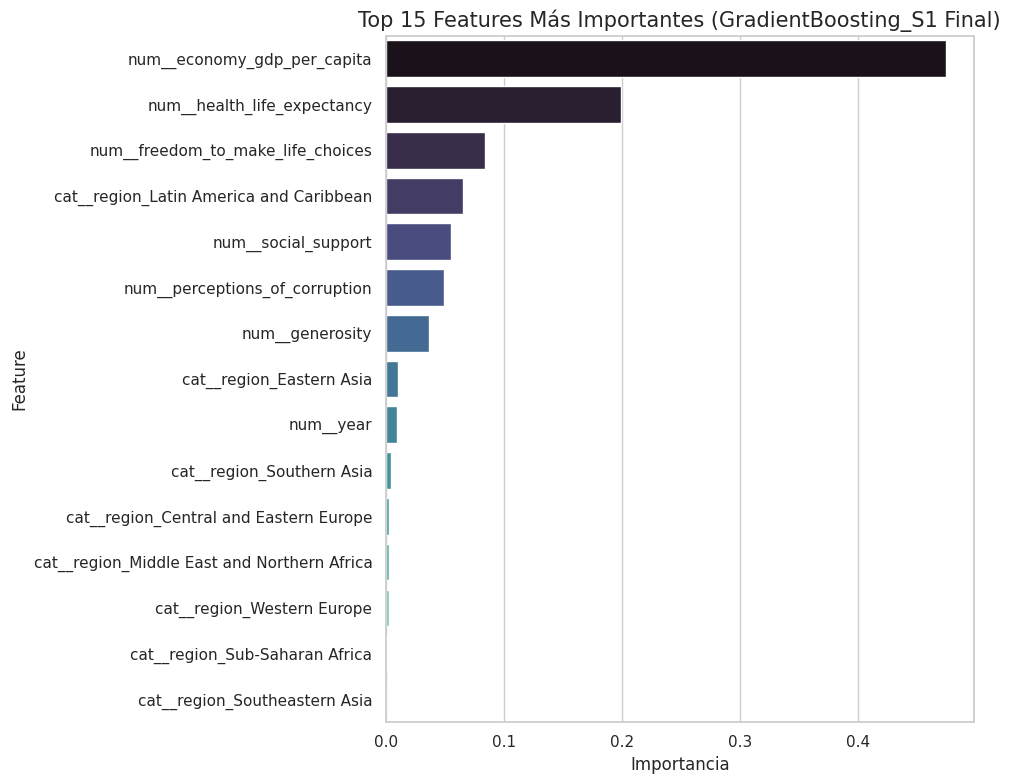

2025-05-20 15:13:46,404 - INFO - 2537394777.py:33 - Gráfico de importancia de features generado para el modelo final.



--- Análisis de Residuos (GradientBoosting_S1 Final) ---


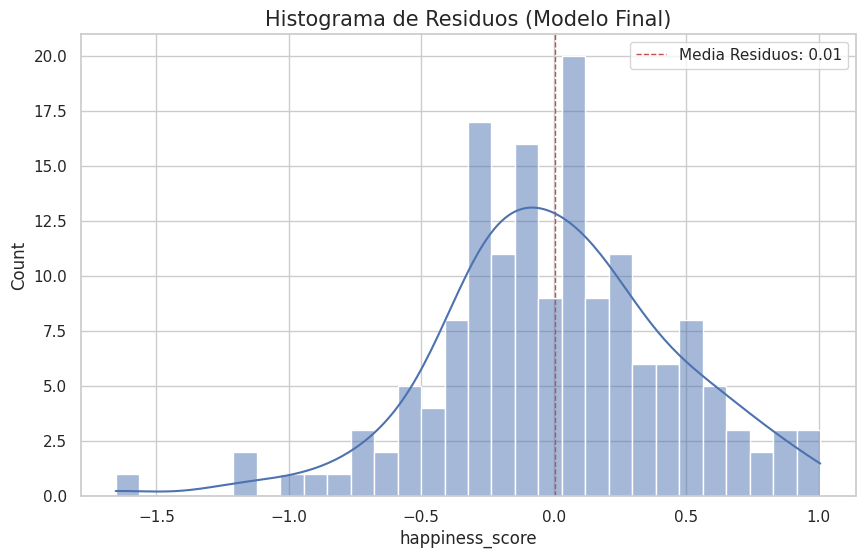

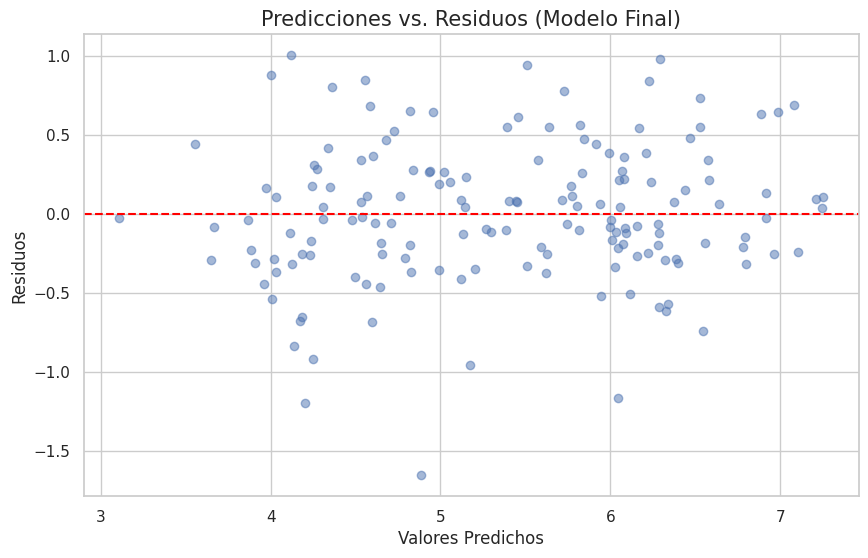

2025-05-20 15:13:46,669 - INFO - 2537394777.py:56 - Análisis de residuos para el modelo final completado.



--- Gráfico de Predichos vs. Reales (Modelo Final) ---


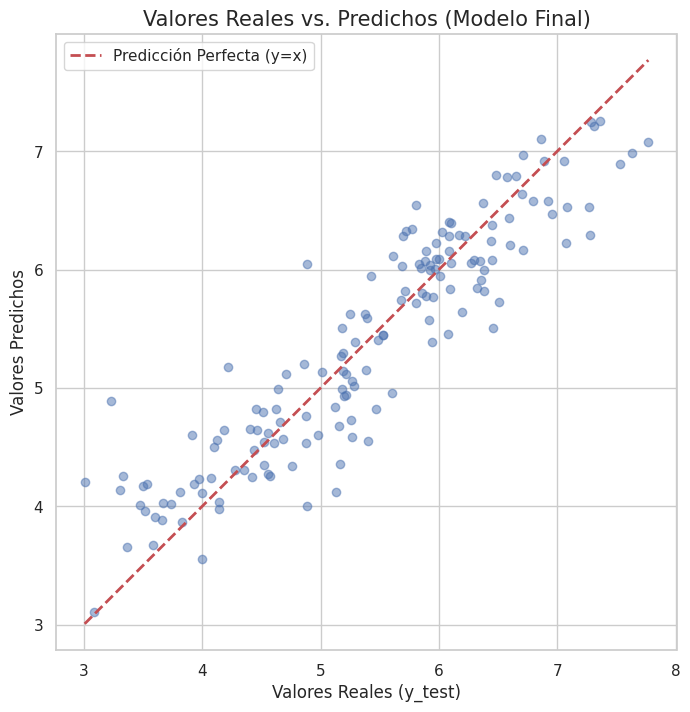

2025-05-20 15:13:46,758 - INFO - 2537394777.py:67 - Gráfico de valores predichos vs. reales para el modelo final generado.


In [7]:
# Celda 7: Análisis Profundo del Modelo Final (GradientBoosting_S1)

if ('gb_s1_pipeline_final' in locals() and gb_s1_pipeline_final is not None and
    'y_pred_test_gb_s1_final' in locals() and y_pred_test_gb_s1_final is not None and
    'y_test' in locals() and y_test is not None):

    logging.info("Realizando análisis profundo del modelo GradientBoosting_S1 final.")
    
    # --- 7.1 Importancia de Features ---
    try:
        preprocessor_fitted_s1 = gb_s1_pipeline_final.named_steps['preprocessor']
        model_fitted_gb_s1 = gb_s1_pipeline_final.named_steps['regressor']
        
        transformed_feature_names_s1_final = preprocessor_fitted_s1.get_feature_names_out()
        
        if hasattr(model_fitted_gb_s1, 'feature_importances_'):
            importances_final = model_fitted_gb_s1.feature_importances_
            feature_importance_df_final = pd.DataFrame({
                'feature': transformed_feature_names_s1_final,
                'importance': importances_final
            }).sort_values(by='importance', ascending=False)

            print("\n--- Importancia de Features (GradientBoosting_S1 Final) ---")
            print(feature_importance_df_final.head(15).to_markdown(index=False))

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df_final.head(15), palette='mako', hue='feature', legend=False)
            plt.title('Top 15 Features Más Importantes (GradientBoosting_S1 Final)', fontsize=15)
            plt.xlabel('Importancia', fontsize=12)
            plt.ylabel('Feature', fontsize=12)
            plt.tight_layout()
            plt.show()
            logging.info("Gráfico de importancia de features generado para el modelo final.")
        else:
            logging.info("El modelo GradientBoosting no proporcionó 'feature_importances_'.")
            
    except Exception as e_fi:
        logging.error(f"Error al obtener/graficar importancia de features: {e_fi}")

    # --- 7.2 Análisis de Residuos ---
    residuals_final = y_test - y_pred_test_gb_s1_final
    print("\n--- Análisis de Residuos (GradientBoosting_S1 Final) ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_final, kde=True, bins=30)
    plt.title('Histograma de Residuos (Modelo Final)', fontsize=15)
    # ... (resto del código de histograma de residuos)
    plt.axvline(residuals_final.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Media Residuos: {residuals_final.mean():.2f}')
    plt.legend(); plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test_gb_s1_final, residuals_final, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Predicciones vs. Residuos (Modelo Final)', fontsize=15)
    # ... (resto del código de scatter de residuos)
    plt.xlabel('Valores Predichos'); plt.ylabel('Residuos'); plt.show()
    logging.info("Análisis de residuos para el modelo final completado.")

    # --- 7.3 Gráfico de Predichos vs. Reales ---
    print("\n--- Gráfico de Predichos vs. Reales (Modelo Final) ---")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_test_gb_s1_final, alpha=0.5)
    # ... (resto del código de scatter predichos vs reales)
    min_val = min(y_test.min(), y_pred_test_gb_s1_final.min()); max_val = max(y_test.max(), y_pred_test_gb_s1_final.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta (y=x)')
    plt.title('Valores Reales vs. Predichos (Modelo Final)', fontsize=15)
    plt.xlabel('Valores Reales (y_test)'); plt.ylabel('Valores Predichos'); plt.legend(); plt.axis('equal'); plt.grid(True); plt.show()
    logging.info("Gráfico de valores predichos vs. reales para el modelo final generado.")
    
else:
    logging.error("Pipeline final o predicciones no disponibles para análisis profundo.")

In [8]:
# Celda 8: Guardar el Modelo GradientBoosting_S1 Final

if ('gb_s1_pipeline_final' in locals() and gb_s1_pipeline_final is not None):
    logging.info("Iniciando el guardado del pipeline GradientBoosting_S1 final.")
    MODELS_DIR = "/home/nicolas/Escritorio/workshops ETL/workshop_3/models"
    os.makedirs(MODELS_DIR, exist_ok=True)
    
    model_filename_final = "GradientBoosting_S1_script.joblib"
    model_filepath_final = os.path.join(MODELS_DIR, model_filename_final)

    try:
        joblib.dump(gb_s1_pipeline_final, model_filepath_final)
        logging.info(f"Pipeline GradientBoosting_S1 final guardado en: {model_filepath_final}")
        print(f"\n--- Modelo Final Guardado ---")
        print(f"El pipeline GradientBoosting_S1 final ha sido guardado en: {model_filepath_final}")
        
        # Guardar también sus métricas finales
        metrics_to_save = {
            'Model': 'GradientBoosting_S1_Final_Optimized',
            'MSE_Test': mse_final, 'RMSE_Test': rmse_final, 
            'MAE_Test': mae_final, 'R2_Test': r2_final,
            'Best_Params': best_params_gb_s1 # Asegúrate que esta variable esté disponible
        }
        info_path = os.path.join(MODELS_DIR, "GradientBoosting_S1_script_info.txt")
        with open(info_path, 'w') as f:
            for key, value in metrics_to_save.items():
                f.write(f"{key}: {value}\n")
        logging.info(f"Información y métricas del modelo final guardadas en: {info_path}")

    except Exception as e:
        logging.error(f"Error al guardar el modelo final: {e}")
else:
    logging.error("El pipeline GradientBoosting_S1 final no está disponible para ser guardado.")

2025-05-20 15:13:46,765 - INFO - 2210002428.py:4 - Iniciando el guardado del pipeline GradientBoosting_S1 final.
2025-05-20 15:13:46,773 - INFO - 2210002428.py:13 - Pipeline GradientBoosting_S1 final guardado en: /home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_script.joblib
2025-05-20 15:13:46,774 - INFO - 2210002428.py:28 - Información y métricas del modelo final guardadas en: /home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_script_info.txt



--- Modelo Final Guardado ---
El pipeline GradientBoosting_S1 final ha sido guardado en: /home/nicolas/Escritorio/workshops ETL/workshop_3/models/GradientBoosting_S1_script.joblib


In [9]:
# el Escenario S1 (S1_RegionOHE_YearNum) era:
# Numéricas (principales): Estandarizadas.
#'region': One-Hot Encoded.
#'year': Tratada como numérica y estandarizada.